Forecast Annual Visition at Utah National Parks

In [123]:
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt

# Ingest Data

Visition data for each park is stored in its own csv file. We collect all data into a single pandas dataframe

In [94]:
#all files in directory
all_files = os.listdir()

#just the csv's with data
csv_files = [file for file in all_files if file.endswith(".csv")]

In [95]:
#initialize the final dataset and types

#set columns and types
data = ['ts', 'visitors', 'park']

#make dataframe
df_visit = pd.DataFrame(columns=data)

In [96]:
#loop through datasets

for f in csv_files:

    #extract name of park from data
    park_name = pd.read_csv(f, nrows=1).iloc[0,0]
    #trim the ' NP' from park name
    park_name = park_name[:-3]

    #read data
    df = pd.read_csv(f, skiprows=3)
    #drop last column since it's a row-wise sum
    df.drop(df.columns[-1], axis=1, inplace=True)
    #rename id column
    df.rename(columns={'Year':'year'}, inplace=True)

    #pivot data
    df_pivot = df.melt(id_vars='year', var_name='month_abbr', value_name='visitors').dropna()

    #clean data
    #extract month number from month name
    def extract_month_number(month_name):
        return pd.to_datetime(month_name, format='%b').month
    
    df_pivot['month_num'] = df_pivot['month_abbr'].apply(extract_month_number)
    #make timestamp
    df_pivot['ts'] = pd.to_datetime(dict(year=df_pivot.year, month=df_pivot.month_num, day=1))
    #convert visitors to numeric
    df_pivot['visitors'] = pd.to_numeric(df_pivot['visitors'].str.replace(',', ''))
    #add park identifier
    df_pivot['park'] = park_name
    #select needed columns
    df_final = df_pivot[['ts', 'visitors', 'park']]

    df_visit = pd.concat([df_visit, df_final], ignore_index=True)

In [100]:
#clean data types
df_visit = df_visit.convert_dtypes()

# Exploratory Data Analysis

We have data starting in 1979 for each park. Each has a monthly observation through March 2024

In [116]:

(
    df_visit
    .groupby('park')
    .agg(
        tot_visitors=('visitors', 'sum'),
        ts_min=('ts', 'min'),
        ts_max=('ts', 'max'),
        tot_months=('ts', 'count')
    )
    .sort_values('tot_visitors', ascending=False)
)

,tot_visitors,ts_min,ts_max,tot_months
park,,,,
Zion,119799075,1979-01-01,2024-03-01,543
Bryce Canyon,54430540,1979-01-01,2024-03-01,543
Arches,39894589,1979-01-01,2024-03-01,543
Capitol Reef,30093495,1979-01-01,2024-03-01,543
Canyonlands,18593469,1979-01-01,2024-03-01,543


<Figure size 800x600 with 0 Axes>

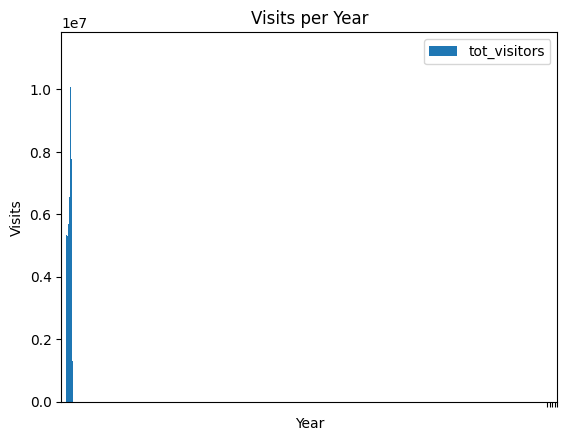

In [165]:
visits_by_year = (
    df_visit
    .groupby(df_visit['ts'].dt.year)
    .agg(
        tot_visitors=('visitors', 'sum')
    )
    .reset_index()
    .rename(columns={'ts':'year'})
)

# Create the bar plot
plt.figure(figsize=(8, 6))  # Adjust figure size (optional)
visits_by_year.plot(kind='bar', x='year', y='tot_visitors')

# Customize the plot (optional)
plt.xlabel('Year')
plt.ylabel('Visits')
plt.title('Visits per Year')

plt.xticks([1979, 1989, 1999, 2009, 2019])

# Display the plot
plt.show()



In [159]:
visits_by_year['year'].unique()[::5]

array([1979, 1984, 1989, 1994, 1999, 2004, 2009, 2014, 2019, 2024])

In [168]:
type(visits_by_year)

pandas.core.frame.DataFrame